In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import igraph

In [2]:

def partition_data(Xcp, NodePositions, MaxBlockSize = 10**6,SquaredXcp= None,
                  TrimmingRadius=float('inf')):
    '''
    # Partition the data by proximity to graph nodes
    # (same step as in K-means EM procedure)
    #
    # Inputs:
    #   X is n-by-m matrix of datapoints with one data point per row. n is
    #       number of data points and m is dimension of data space.
    #   NodePositions is k-by-m matrix of embedded coordinates of graph nodes,
    #       where k is number of nodes and m is dimension of data space.
    #   MaxBlockSize integer number which defines maximal number of
    #       simultaneously calculated distances. Maximal size of created matrix
    #       is MaxBlockSize-by-k, where k is number of nodes.
    #   SquaredX is n-by-1 vector of data vectors length: SquaredX = sum(X.^2,2);
    #   TrimmingRadius (optional) is squared trimming radius.
    #
    # Outputs
    #   partition is n-by-1 vector. partition[i] is number of the node which is
    #       associated with data point X[i, ].
    #   dists is n-by-1 vector. dists[i] is squared distance between the node with
    #       number partition[i] and data point X[i, ].
    '''
    if SquaredXcp is None:
      SquaredXcp = np.sum(Xcp**2,1)[:,np.newaxis]
    NodePositionscp = np.asarray(NodePositions)
    n = Xcp.shape[0]
    partition = np.zeros((n, 1), dtype=int)
    dists = np.zeros((n, 1))
    all_dists = np.zeros((n, NodePositions.shape[0] ))
    # Calculate squared length of centroids
    cent = NodePositionscp.T
    centrLength = (cent**2).sum(axis=0)
    # Process partitioning without trimming
    for i in range(0, n, MaxBlockSize):
        # Define last element for calculation
        last = i+MaxBlockSize
        if last > n:
            last = n
        # Calculate distances
        d = SquaredXcp[i:last] + centrLength-2*np.dot(Xcp[i:last, ], cent)
        tmp = d.argmin(axis=1)
        partition[i:last] = tmp[:, np.newaxis]
        dists[i:last] = d[np.arange(d.shape[0]), tmp][:, np.newaxis]
        all_dists[i:last,:] = d
    # Apply trimming
    if not np.isinf(TrimmingRadius):
        ind = dists > (TrimmingRadius**2)
        partition[ind] = -1
        dists[ind] = TrimmingRadius**2
    
    
    return np.asarray(partition), np.asarray(dists), np.asarray(all_dists)



def find_branches( graph, verbose = 0 ):
  '''
  #' Computes "branches" of the graph, i.e. paths from branch vertex (or terminal vertex)  to branch vertex (or terminal vertex)
  #' Can process disconnected graphs. Stand-alone point - is "branch".
  #' Circle is exceptional case - each circle (can be several connected components) is "branch"
  #'
  #' @param g - graph (igraph) 
  #' @param verbose - details output
  #' 
  #' @examples
  #' import igraph
  #' g = igraph.Graph.Lattice([3,3], circular = False ) 
  #' dict_output = find_branches(g, verbose = 1000)
  #' print( dict_output['branches'] )
  '''
  #verbose = np.inf
  #
  g = graph
  n_vertices_input_graph =   g.vcount()  
  set_vertices_input_graph = set( range( n_vertices_input_graph  ) ) 

  dict_output = {}
  #dict_output['branches'] = found_branches.copy()

  # Main variables for process: 
  found_branches = []
  processed_edges = []
  processed_vertices = set()

  ############################################################################################################################################
  # Connected components loop:
  count_connected_components = 0 
  while True: # Need loop if graph has several connected components, each iteration - new component
    count_connected_components += 1

    def find_start_vertex(g, processed_vertices ): 
      '''
      #' Find starting vertex for branches-search algorithm. 
      #' It should be either branching vertex (i.e. degree >2) or terminal vertex (i.e. degree 0 or 1), in special case when unprocessed part of graph is union of circles - processed outside function
      '''
      n_vertices = n_vertices_input_graph #  = g.count()# 
      if n_vertices == len( processed_vertices ):
        return -1,-1 # All vertices proccessed
      flag_found_start_vertex = 0 
      for v in set_vertices_input_graph: 
        if v in processed_vertices: continue
        if g.degree(v) != 2:
          flag_found_start_vertex = 1
          return v, flag_found_start_vertex
      return -1, 0 # All unprocessed vertices are of degree 2, that means graph is circle of collection or collection of circles

    ############################################################################################################################################
    # Starting point initialization. End process condtion.
    #
    # Set correctly the starting vertex for the algorithm
    # That should be branch vertex or terminal vertex, only in case graph is set of circles(disconnected) we take arbitrary vertex as initial, each circle will be a branch
    initial_vertex, flag_found_start_vertex = find_start_vertex(g, processed_vertices )
    if   flag_found_start_vertex > 0:
      current_vertex  = initial_vertex
    elif flag_found_start_vertex == 0: # All unprocessed vertices are of degree 2, that means graph is circle of collection or collection of circles
      # Take any unprocessed element 
      tmp_set = set_vertices_input_graph  - processed_vertices
      current_vertex = tmp_set.pop()
    else:
      # No vertices to process 
      if verbose >= 10:
        print('Process finished')
      dict_output['branches'] = found_branches.copy()
      return dict_output
      #break

    ############################################################################################################################################
    # Core function implementing "Breath First Search" like algorithm
    # with some updates in storage, since we need to arrange edges into "branches"
    def find_branches_core( current_vertex , previous_vertex, current_branch  ):
      core_call_count[0] = core_call_count[0] + 1
      if verbose >= 1000:
        print(core_call_count[0], 'core call.', 'current_vertex', current_vertex , 'previous_vertex', previous_vertex,'found_branches',found_branches, 'current_branch',current_branch )

      processed_vertices.add(current_vertex)
      neis = g.neighbors(current_vertex) 
      if len(neis) == 0: # current_vertex is standalone vertex
        found_branches.append( [current_vertex] )
        return 
      if len(neis) == 1: # current_vertex is terminal vertex
        if neis[0] == previous_vertex:
          current_branch.append( current_vertex  )
          found_branches.append( current_branch.copy() )
          # processed_edges.append(  set([current_vertex , previous_vertex])  )  
          return 
        else:
          # That case may happen if we just started from that vertex
          # Because it has one neigbour, but it is not previous_vertex, so it is None, which is only at start 
          current_branch = [current_vertex] # , neis[0] ] # .append( current_vertex  )
          processed_edges.append(  set([current_vertex , neis[0] ])  )
          find_branches_core( current_vertex = neis[0] , previous_vertex = current_vertex, current_branch = current_branch )  
          return
      if len(neis) == 2: # 
        # continue the current branch:
        current_branch.append( current_vertex  )
        next_vertex = neis[0]
        if next_vertex == previous_vertex: next_vertex = neis[1]
        if next_vertex in processed_vertices: # Cannot happen for trees, but may happen if graph has a loop
          if set([current_vertex , next_vertex]) not in processed_edges:
            current_branch.append( next_vertex  )
            found_branches.append( current_branch.copy() )
            processed_edges.append(  set([current_vertex , next_vertex])  )
            return 
          else:
            return
        processed_edges.append(  set([current_vertex , next_vertex])  )          
        find_branches_core( current_vertex=next_vertex , previous_vertex = current_vertex, current_branch = current_branch )
        return
      if len(neis)  > 2 : #Branch point
        if  previous_vertex is not None:
          # Stop current branch
          current_branch.append( current_vertex  )
          found_branches.append(current_branch.copy())
        for next_vertex in neis:
            if next_vertex ==  previous_vertex:    continue
            if next_vertex in  processed_vertices: # Cannot happen for trees, but may happen if graph has a loop
              if set([current_vertex , next_vertex]) not in processed_edges:
                processed_edges.append(  set([current_vertex , next_vertex])  )
                found_branches.append( [current_vertex, next_vertex ] )
              continue
            current_branch = [current_vertex]
            processed_edges.append(  set([current_vertex , next_vertex])  )
            find_branches_core( current_vertex = next_vertex , previous_vertex = current_vertex , current_branch = current_branch)
      return

    ############################################################################################################################################
    # Core function call. It should process the whole connected component
    if verbose >= 10:
      print('Start process count_connected_components', count_connected_components, 'initial_vertex', current_vertex)
    processed_vertices.add(current_vertex)
    core_call_count = [0]
    find_branches_core( current_vertex = current_vertex , previous_vertex = None , current_branch = [])

    ############################################################################################################################################
    # Output of results for connected component
    if verbose >=10:
      print('Connected component ', count_connected_components, ' processed ')
      print('Final found_branches',found_branches)
      print('N Final found_branches', len( found_branches) )


def branch_labler( X , graph, nodes_positions, verbose = 0 ):
  '''
  #' Labels points of the dataset X by "nearest"-"branches" of graph.
  #' 
  #'
  #' @examples
  # X = np.array( [[0.1,0.1], [0.1,0.2], [1,2],[3,4],[5,0]] )
  # nodes_positions = np.array( [ [0,0], [1,0], [0,1], [1,1] ]  ) 
  # import igraph
  # g = igraph.Graph(); g.add_vertices(  4  )
  # g.add_edges([[0,1],[0,2],[0,3]])
  # vec_labels_by_branches = branch_labler( X , g, nodes_positions )
  '''
  #####################################################################################
  # Calculate branches and clustering by vertices of graph 
  dict_output = find_branches(graph, verbose = verbose )
  if verbose >=100:
    print('Function find_branches results branches:',  dict_output['branches'] )
  vec_labels_by_vertices, dists, all_dists = partition_data(X, nodes_positions) # np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4], [10,20,30,40]]), [[1,2,3,4], [10,20,30,40]], 10**6)#,SquaredX)
  vec_labels_by_vertices = vec_labels_by_vertices.ravel()
  if verbose >=100:
    print('Function partition_data returns: vec_labels_by_vertices.shape, dists.shape, all_dists.shape', vec_labels_by_vertices.shape, dists.shape, all_dists.shape )
  #####################################################################################

  n_vertices = len( nodes_positions)
  branches = dict_output['branches']

  #####################################################################################
  # Create dictionary vertex to list of branches it belongs to  
  dict_vertex2branches = {}
  for i,b in enumerate( branches):
    for v in b:
      if v in dict_vertex2branches.keys():
        dict_vertex2branches[v].append(i)
      else:
        dict_vertex2branches[v] = [i]
  if verbose >=100:
    print( 'dict_vertex2branches', dict_vertex2branches )


  #####################################################################################
  # create list of branch and non-branch vertices
  list_branch_vertices = []
  list_non_branch_vertices = []
  for v in dict_vertex2branches:
    list_branches = dict_vertex2branches[v]
    if len(list_branches) == 1:
      list_non_branch_vertices.append(v)
    else:
      list_branch_vertices.append(v)
  if verbose >=100:  
    print('list_branch_vertices, list_non_branch_vertices', list_branch_vertices, list_non_branch_vertices)

  #####################################################################################
  # First stage of creation of final output - create labels by branches vector 
  # After that step it will be only correct for non-branch points 
  vec_vertex2branch = np.zeros(  n_vertices  ) 
  for i in range( n_vertices  ):
    vec_vertex2branch[i] = dict_vertex2branches[i][0]
  vec_labels_by_branches = vec_vertex2branch[ vec_labels_by_vertices ] 
  if verbose >= 100:
    print('branches', branches)
    print('vec_labels_by_branches', vec_labels_by_branches)

  #####################################################################################
  # Second stage of creation of final output - 
  # make correct calculation for branch-vertices create labels by correct branches 
  for branch_vertex in list_branch_vertices:
    if verbose >= 100:
      print('all_dists.shape', all_dists.shape)
    def labels_for_one_branch_vertex( branch_vertex , vec_labels_by_vertices,  all_dists ):
      '''
      #' For the branch_vertex re-labels points of dataset which were labeled by it to label by "correct branch".
      #' "Correct branch" label is a branch 'censored'-nearest to given point. 
      #' Where 'censored'-nearest means the minimal distance between the point  and all points of the branch except the given branch_vertex
      #'
      #' Function changes vec_labels_by_branches defined above
      #' Uses vec_labels_by_vertices defined above - vector of same length as dataset, which contains labels by vertices 
      '''

      mask = vec_labels_by_vertices.ravel() == branch_vertex # Select part of the dataset which is closest to branch_vertex

      # Allocate memory for array: first coordinate - point of dataset[mask],  second coordinate - branch number , for all branches contianing given vertex (i.e. branch_vertex) 
      # For each point of dataset[mask] it contains 'censored'-distances to "branches" adjoint to "branch_vertex", 
      # 'censored' means minimal over vertices belonging to  distance to branches (excluding branch_vertex)
      dist2branches = np.zeros( [ mask.sum(), len(dict_vertex2branches[branch_vertex] )  ] )
      list_branch_ids = [] # that will be necessary to renumerate local number to branch_ids 
      for i,branch_id in enumerate( dict_vertex2branches[branch_vertex] ):
        list_branch_ids.append(branch_id)
        # Create list of vertices of current branch, with EXCLUSION of branch_vertex
        branch_vertices_wo_given_branch_vertex = [v for v in branches[branch_id] if v != branch_vertex ]
        # For all points of dataset[mask] calculate minimal distances to given branch (with exclusion of branch_point), i.e. mininal difference for  
        if verbose >= 1000:
          print('mask.shape, all_dists.shape', mask.shape, all_dists.shape)
        dist2branches[ : ,i ] = np.min( all_dists[mask,:][:,branch_vertices_wo_given_branch_vertex], 1 ).ravel()

      vec_labels_by_branches[mask] = np.array(list_branch_ids)[ np.argmin( dist2branches, 1) ]
    labels_for_one_branch_vertex( branch_vertex, vec_labels_by_vertices,  all_dists  )

    if verbose >= 10:    
      print('Output: vec_labels_by_branches', vec_labels_by_branches)


  return vec_labels_by_branches


# Examples find_branches usage on different graph

## Simplest three-branch graph

Type of main output: <class 'list'>
Main output: [[0, 1, 2], [2, 3, 4], [2, 5, 6]]
Nodes in 0-th branch: [0, 1, 2]
Nodes in 1-th branch: [2, 3, 4]
Nodes in 2-th branch: [2, 5, 6]


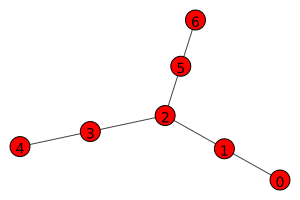

In [3]:


# Create test graph:
g = igraph.Graph()
g.add_vertices(7)
g.add_edges([(0,1), (1,2), (2,3),(3,4) , (2,5), (5,6)]) # Add list of edges 

# Launch find_branches
dict_output = find_branches(g, verbose = 0)# 1000)

# Print main results of find_branches
print('Type of main output:', type(dict_output['branches'] ) )
print( 'Main output:', dict_output['branches'] )
for i,list_nodes_in_each_branch in enumerate( dict_output['branches'] ) :
    print('Nodes in %d-th branch:'%(i) ,list_nodes_in_each_branch  )
    
    
# Plot graph
layout = g.layout('kk') # kk - Kamada-Kawai layout - one of the most popular layouts  # List of possible layouts is here: https://igraph.org/python/doc/igraph.Graph-class.html#layout
visual_style = {}
#visual_style["vertex_color"] = ['green' for v in g.vs]
visual_style["vertex_label"] = range(g.vcount()) 
visual_style["vertex_size"] = 20
igraph.plot(g, layout = layout, **visual_style, bbox = (300,200) )



## Example - lattice graph 

Type of main output: <class 'list'>
Main output: [[1, 0, 3], [3, 4], [4, 1], [4, 5], [5, 2, 1], [5, 8, 7], [7, 4], [7, 6, 3]]
Nodes in 0-th branch: [1, 0, 3]
Nodes in 1-th branch: [3, 4]
Nodes in 2-th branch: [4, 1]
Nodes in 3-th branch: [4, 5]
Nodes in 4-th branch: [5, 2, 1]
Nodes in 5-th branch: [5, 8, 7]
Nodes in 6-th branch: [7, 4]
Nodes in 7-th branch: [7, 6, 3]


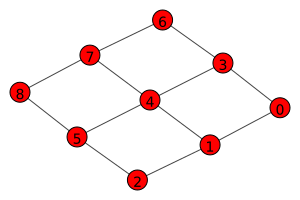

In [4]:
g = igraph.Graph.Lattice([3,3], circular = False ) 

# Launch find_branches
dict_output = find_branches(g, verbose = 0)# 1000)

# Print main results of find_branches
print('Type of main output:', type(dict_output['branches'] ) )
print( 'Main output:', dict_output['branches'] )
for i,list_nodes_in_each_branch in enumerate( dict_output['branches'] ) :
    print('Nodes in %d-th branch:'%(i) ,list_nodes_in_each_branch  )
    
    
# Plot graph
layout = g.layout('kk') # kk - Kamada-Kawai layout - one of the most popular layouts  # List of possible layouts is here: https://igraph.org/python/doc/igraph.Graph-class.html#layout
visual_style = {}
#visual_style["vertex_color"] = ['green' for v in g.vs]
visual_style["vertex_label"] = range(g.vcount()) 
visual_style["vertex_size"] = 20
igraph.plot(g, layout = layout, **visual_style, bbox = (300,200) )


## Line graph - just one branch

Type of main output: <class 'list'>
Main output: [[0, 1, 2, 3, 4]]
Nodes in 0-th branch: [0, 1, 2, 3, 4]


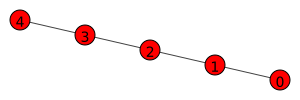

In [5]:
g = igraph.Graph.Lattice([5,1], circular = False ) 

# Launch find_branches
dict_output = find_branches(g, verbose = 0)# 1000)

# Print main results of find_branches
print('Type of main output:', type(dict_output['branches'] ) )
print( 'Main output:', dict_output['branches'] )
for i,list_nodes_in_each_branch in enumerate( dict_output['branches'] ) :
    print('Nodes in %d-th branch:'%(i) ,list_nodes_in_each_branch  )
    
    
# Plot graph
layout = g.layout('kk') # kk - Kamada-Kawai layout - one of the most popular layouts  # List of possible layouts is here: https://igraph.org/python/doc/igraph.Graph-class.html#layout
visual_style = {}
#visual_style["vertex_color"] = ['green' for v in g.vs]
visual_style["vertex_label"] = range(g.vcount()) 
visual_style["vertex_size"] = 20
igraph.plot(g, layout = layout, **visual_style, bbox = (300,100) )


## Special example - cycle graph

It is rather a matter of convention what to call by branch for case of circle graph.
We will consider the whole circle as a branch, and to distinguish it from the line graph,
we orginaze the output such that the firth element is repeated at the end of the output. (Choice of the "first" element is, of course, arbitrary). 

Type of main output: <class 'list'>
Main output: [[0, 1, 2, 3, 4, 0]]
Nodes in 0-th branch: [0, 1, 2, 3, 4, 0]


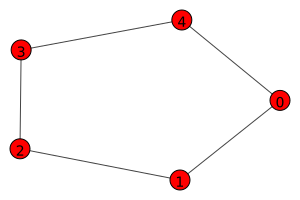

In [6]:
g = igraph.Graph.Lattice([5,1], circular = True ) 

# Launch find_branches
dict_output = find_branches(g, verbose = 0)# 1000)

# Print main results of find_branches
print('Type of main output:', type(dict_output['branches'] ) )
print( 'Main output:', dict_output['branches'] )
for i,list_nodes_in_each_branch in enumerate( dict_output['branches'] ) :
    print('Nodes in %d-th branch:'%(i) ,list_nodes_in_each_branch  )
    
    
# Plot graph
layout = g.layout('kk') # kk - Kamada-Kawai layout - one of the most popular layouts  # List of possible layouts is here: https://igraph.org/python/doc/igraph.Graph-class.html#layout
visual_style = {}
#visual_style["vertex_color"] = ['green' for v in g.vs]
visual_style["vertex_label"] = range(g.vcount()) 
visual_style["vertex_size"] = 20
igraph.plot(g, layout = layout, **visual_style, bbox = (300,200) )


## Example with disconnected graph 

Type of main output: <class 'list'>
Main output: [[0, 1, 2, 3, 4], [5, 6], [7]]
Nodes in 0-th branch: [0, 1, 2, 3, 4]
Nodes in 1-th branch: [5, 6]
Nodes in 2-th branch: [7]


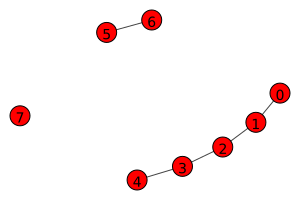

In [7]:


# Create test graph:
g = igraph.Graph()
g.add_vertices(8)
g.add_edges([(0,1), (1,2), (2,3),(3,4), (5,6) ]) # Add list of edges 

# Launch find_branches
dict_output = find_branches(g, verbose = 0)# 1000)

# Print main results of find_branches
print('Type of main output:', type(dict_output['branches'] ) )
print( 'Main output:', dict_output['branches'] )
for i,list_nodes_in_each_branch in enumerate( dict_output['branches'] ) :
    print('Nodes in %d-th branch:'%(i) ,list_nodes_in_each_branch  )
    
    
# Plot graph
layout = g.layout('kk') # kk - Kamada-Kawai layout - one of the most popular layouts  # List of possible layouts is here: https://igraph.org/python/doc/igraph.Graph-class.html#layout
visual_style = {}
#visual_style["vertex_color"] = ['green' for v in g.vs]
visual_style["vertex_label"] = range(g.vcount()) 
visual_style["vertex_size"] = 20
igraph.plot(g, layout = layout, **visual_style, bbox = (300,200) )



## Example tree like graph.  Verbose turned on.  

Turn on verbose output for find_branches 

Start process count_connected_components 1 initial_vertex 1
1 core call. current_vertex 1 previous_vertex None found_branches [] current_branch []
2 core call. current_vertex 0 previous_vertex 1 found_branches [] current_branch [1]
3 core call. current_vertex 2 previous_vertex 0 found_branches [] current_branch [1, 0]
4 core call. current_vertex 5 previous_vertex 2 found_branches [[1, 0, 2]] current_branch [2]
5 core call. current_vertex 11 previous_vertex 5 found_branches [[1, 0, 2]] current_branch [2, 5]
6 core call. current_vertex 6 previous_vertex 2 found_branches [[1, 0, 2], [2, 5, 11]] current_branch [2]
7 core call. current_vertex 3 previous_vertex 1 found_branches [[1, 0, 2], [2, 5, 11], [2, 6]] current_branch [1]
8 core call. current_vertex 7 previous_vertex 3 found_branches [[1, 0, 2], [2, 5, 11], [2, 6], [1, 3]] current_branch [3]
9 core call. current_vertex 8 previous_vertex 3 found_branches [[1, 0, 2], [2, 5, 11], [2, 6], [1, 3], 

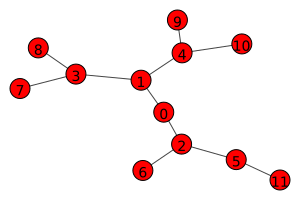

In [8]:

g = igraph.Graph.Tree(12,2)# Lattice([3,3], circular = False ) 

# Launch find_branches
print('Turn on verbose output for find_branches ')
print()
dict_output = find_branches(g, verbose =  1000)
print()

# Print main results of find_branches
print('Type of main output:', type(dict_output['branches'] ) )
print( 'Main output:', dict_output['branches'] )
for i,list_nodes_in_each_branch in enumerate( dict_output['branches'] ) :
    print('Nodes in %d-th branch:'%(i) ,list_nodes_in_each_branch  )
    
    
# Plot graph
layout = g.layout('kk') # kk - Kamada-Kawai layout - one of the most popular layouts  # List of possible layouts is here: https://igraph.org/python/doc/igraph.Graph-class.html#layout
visual_style = {}
#visual_style["vertex_color"] = ['green' for v in g.vs]
visual_style["vertex_label"] = range(g.vcount()) 
visual_style["vertex_size"] = 20
igraph.plot(g, layout = layout, **visual_style, bbox = (300,200) )


# Examples - clustering data by graph branches - function branch_labler

## Auxilliary plot function 

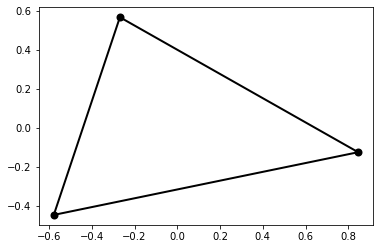

In [9]:
from sklearn.decomposition import PCA
try :
    import umap
except:
    print('cannot import umap')

def plot_graph(edges, nodes_positions, data = None, dim_reduction = 'PCA', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = 'tab:red', data_transparency_alpha = 0.9,
               umap_n_neighbors = 50, umap_min_dist = 0.99):
  '''
  #' Plots graphs defined by edges and nodes_positions, optionally - scatter plot the "data" on the same plot,
  #' Optionally performs PCA/etc (depending on dim_reduction)
  #'
  #' @param edges Nx2-shape matrix with edges ends, i.e. edges[k,0], edges[k,1] - ends of k-th edge  
  #' @param nodes_positions  matrix of nodes positions 
  #' @param data  "original dataset", basically arbitrary dataset for scatter plot, it should have same shape[1] as nodes_positions
  #' @param plot_data  True/False - to scatterplot or not data
  #' @param dim_reduction  'PCA', 'plot_first2axis', 'umap'
  #' @param data_color can be a vector or predefined color - argument for c = data_color in scatter

  #' @examples
  # edges = np.array([ [0,1],[1,2],[2,0] ] )
  # nodes_positions = np.random.rand(3,10) # 3 points in 10d space
  # plot_graph(edges, nodes_positions)
  #
  # t = elpigraph_output
  # edges = t[0]['Edges'][0]
  # nodes_positions = t[0]['NodePositions']
  # plot_graph(edges, nodes_positions)
  '''
  str_dim_reduction = dim_reduction
  if dim_reduction in ['PCA', 'umap' ]: #  not 'plot_first2axis':
    if dim_reduction.upper() == 'PCA':
      reducer = PCA()
    elif dim_reduction.lower() == 'umap':
      n_neighbors = umap_n_neighbors#  50
      min_dist= umap_min_dist # 0.99
      #n_components=n_components
      reducer = umap.UMAP( n_neighbors=n_neighbors,        min_dist=min_dist, n_components = 2)

    if data is not None:
      data2 = reducer.fit_transform(data)
      if plot_data == True:
        if data_color is None:
          plt.scatter(data2[:,0],data2[:,1], linewidth = data_linewidth , alpha = data_transparency_alpha)# ,cmap=plt.cm.Paired) # ,c=np.array(irx) 
          plt.xlabel(str_dim_reduction+'1')
          plt.ylabel(str_dim_reduction+'2')
        else:
          plt.scatter(data2[:,0],data2[:,1] ,cmap=plt.cm.Paired,c= data_color, linewidth = data_linewidth, alpha = data_transparency_alpha ) 
          plt.xlabel(str_dim_reduction+'1')
          plt.ylabel(str_dim_reduction+'2')
    else:
      reducer.fit(nodes_positions)

    nodes_positions2 = reducer.transform( nodes_positions )
  else:
    if plot_data == True:
      if data is not None:
        if data_color is None:
          plt.scatter(data[:,0],data[:,1] , linewidth = linewidth, alpha = data_transparency_alpha )# ,cmap=plt.cm.Paired) # ,c=np.array(irx) 
        else:
          plt.scatter(data[:,0],data[:,1] ,cmap=plt.cm.Paired,c= data_color , linewidth = data_linewidth, alpha = data_transparency_alpha ) 
    nodes_positions2 = nodes_positions

  plt.scatter(nodes_positions2[:,0],nodes_positions2[:,1],c = graph_color, linewidth = graph_linewidth)#, cmap=plt.cm.Paired)

  edgeCount = edges.shape[0]
  for k in range(edgeCount):
    n0 = edges[k,0]
    n1 = edges[k,1]
    x_line = [ nodes_positions2[n0,0],  nodes_positions2[n1,0] ]
    y_line = [ nodes_positions2[n0,1],  nodes_positions2[n1,1] ]
    plt.plot(x_line, y_line, graph_color, linewidth = graph_linewidth) # 'black')

    
edges = np.array([ [0,1],[1,2],[2,0] ] )
nodes_positions = np.random.rand(3,10) # 3 points in 10d space
plot_graph(edges, nodes_positions)    

# Example 1 

vec_labels_by_branches type: <class 'numpy.ndarray'>  ; vec_labels_by_branches shape: (1000,)


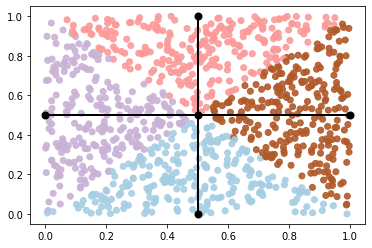

In [10]:
# Create random points in square [0,1]^2
X = np.random.rand(1000,2)

# Create graph 
g = igraph.Graph()
g.add_vertices(5)
list_edges = [(0,1), (0,2), (0,3),(0,4) ]
g.add_edges( list_edges ) # Add list of edges 
nodes_positions = np.array([[0.5,0.5],[0.5,0],[0.5,1],[0,0.5],[1,0.5]])

# 
vec_labels_by_branches = branch_labler( X , g, nodes_positions )
print('vec_labels_by_branches type:', type(vec_labels_by_branches), ' ; vec_labels_by_branches shape:',  vec_labels_by_branches.shape )

plot_graph(np.array(g.get_edgelist()), nodes_positions, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches, data_transparency_alpha = 0.9 )


## Example 2 

vec_labels_by_branches type: <class 'numpy.ndarray'>  ; vec_labels_by_branches shape: (1000,)


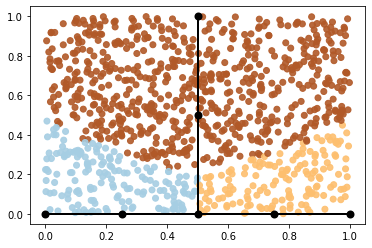

In [11]:
# Create random points in square [0,1]^2
X = np.random.rand(1000,2)

# Create graph 
g = igraph.Graph()
g.add_vertices(7)
list_edges = [(0,1), (1,2), (2,3),(3,4), (2,5) , (5,6) ]
g.add_edges( list_edges ) # Add list of edges 
nodes_positions = np.array([[0,0],[0.25,0],[0.5,0], [0.75,0],[1,0], [0.5,0.5], [0.5,1]    ])

# 
vec_labels_by_branches = branch_labler( X , g, nodes_positions )
print('vec_labels_by_branches type:', type(vec_labels_by_branches), ' ; vec_labels_by_branches shape:',  vec_labels_by_branches.shape )

plot_graph(np.array(g.get_edgelist()), nodes_positions, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches, data_transparency_alpha = 0.9 )


# Score calculation for graphs similiraty via clustering 

vec_labels_by_branches type: <class 'numpy.ndarray'>  ; vec_labels_by_branches shape: (1000,)


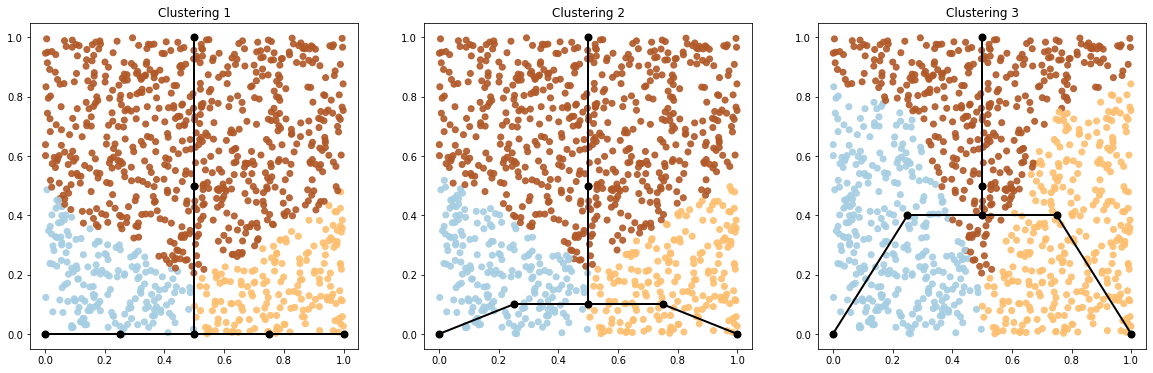

,Adjusted Rand Index Score,Adjusted Mutual Information Score,Fowlkes-Mallows Score,V-measure Score
between 1 and 2,0.817941,0.783104,0.901821,0.783573
between 1 and 3,0.298413,0.458497,0.584054,0.459589
between 2 and 3,0.401971,0.518311,0.631842,0.519250


In [12]:
# Create random points in square [0,1]^2
X = np.random.rand(1000,2)

# Create graph 
g = igraph.Graph()
g.add_vertices(7)
list_edges = [(0,1), (1,2), (2,3),(3,4), (2,5) , (5,6) ]
g.add_edges( list_edges ) # Add list of edges 
nodes_positions = np.array([[0,0],[0.25,0],[0.5,0], [0.75,0],[1,0], [0.5,0.5], [0.5,1]    ])

# 
vec_labels_by_branches = branch_labler( X , g, nodes_positions )
print('vec_labels_by_branches type:', type(vec_labels_by_branches), ' ; vec_labels_by_branches shape:',  vec_labels_by_branches.shape )

vec_labels_by_branches  = []
# Create figure
fig = plt.figure(figsize=(20, 6))
n_subplots_x = 3


fig.add_subplot(1, n_subplots_x , 1) 

# Create graph 
g = igraph.Graph()
g.add_vertices(7)
list_edges = [(0,1), (1,2), (2,3),(3,4), (2,5) , (5,6) ]
g.add_edges( list_edges ) # Add list of edges 
nodes_positions = np.array([[0,0],[0.25,0],[0.5,0], [0.75,0],[1,0], [0.5,0.5], [0.5,1]    ])

vec_labels_by_branches1 = branch_labler( X , g, nodes_positions )

plot_graph(np.array(g.get_edgelist()), nodes_positions, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches1, data_transparency_alpha = 0.9 )
plt.title('Clustering 1')


fig.add_subplot(1, n_subplots_x , 2) 

# Create graph 
g = igraph.Graph()
g.add_vertices(7)
list_edges = [(0,1), (1,2), (2,3),(3,4), (2,5) , (5,6) ]
g.add_edges( list_edges ) # Add list of edges 
nodes_positions2 = np.array([[0,0],[0.25,0.1],[0.5,0.1], [0.75,0.1],[1,0], [0.5,0.5], [0.5,1]    ])

vec_labels_by_branches2 = branch_labler( X , g, nodes_positions2 )

plot_graph(np.array(g.get_edgelist()), nodes_positions2, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches2, data_transparency_alpha = 0.9 )
plt.title('Clustering 2')

fig.add_subplot(1, n_subplots_x , 3) 

g = igraph.Graph()
g.add_vertices(7)
list_edges = [(0,1), (1,2), (2,3),(3,4), (2,5) , (5,6) ]
g.add_edges( list_edges ) # Add list of edges 
nodes_positions3 = np.array([[0,0],[0.25,0.4],[0.5,0.4], [0.75,0.4],[1,0], [0.5,0.5], [0.5,1]    ])

vec_labels_by_branches3 = branch_labler( X , g, nodes_positions3 )

plot_graph(np.array(g.get_edgelist()), nodes_positions3, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches3, data_transparency_alpha = 0.9 )
plt.title('Clustering 3')



plt.show()

from sklearn import metrics

df = pd.DataFrame()
df.loc['between 1 and 2' , 'Adjusted Rand Index Score'] =   metrics.adjusted_rand_score(vec_labels_by_branches1,vec_labels_by_branches2 ) 
df.loc['between 1 and 3' , 'Adjusted Rand Index Score'] =   metrics.adjusted_rand_score(vec_labels_by_branches1,vec_labels_by_branches3 ) 
df.loc['between 2 and 3' , 'Adjusted Rand Index Score'] =   metrics.adjusted_rand_score(vec_labels_by_branches2,vec_labels_by_branches3 ) 
 

df.loc['between 1 and 2' , 'Adjusted Mutual Information Score'] =   metrics.adjusted_mutual_info_score(vec_labels_by_branches1,vec_labels_by_branches2 ) 
df.loc['between 1 and 3' , 'Adjusted Mutual Information Score'] =   metrics.adjusted_mutual_info_score(vec_labels_by_branches1,vec_labels_by_branches3 ) 
df.loc['between 2 and 3' , 'Adjusted Mutual Information Score'] =   metrics.adjusted_mutual_info_score(vec_labels_by_branches2,vec_labels_by_branches3 ) 

df.loc['between 1 and 2' , 'Fowlkes-Mallows Score'] =   metrics.fowlkes_mallows_score(vec_labels_by_branches1,vec_labels_by_branches2 ) 
df.loc['between 1 and 3' , 'Fowlkes-Mallows Score'] =   metrics.fowlkes_mallows_score(vec_labels_by_branches1,vec_labels_by_branches3 ) 
df.loc['between 2 and 3' , 'Fowlkes-Mallows Score'] =   metrics.fowlkes_mallows_score(vec_labels_by_branches2,vec_labels_by_branches3 ) 

df.loc['between 1 and 2' , 'V-measure Score'] =   metrics.v_measure_score(vec_labels_by_branches1,vec_labels_by_branches2 ) 
df.loc['between 1 and 3' , 'V-measure Score'] =   metrics.v_measure_score(vec_labels_by_branches1,vec_labels_by_branches3 ) 
df.loc['between 2 and 3' , 'V-measure Score'] =   metrics.v_measure_score(vec_labels_by_branches2,vec_labels_by_branches3 ) 


df

In [13]:
print('Adjusted Rand Index ')
print('between 1 and 2:', metrics.adjusted_rand_score(vec_labels_by_branches1,vec_labels_by_branches2 ) )
print('between 1 and 3:', metrics.adjusted_rand_score(vec_labels_by_branches1,vec_labels_by_branches3 ) )
print('between 2 and 3:', metrics.adjusted_rand_score(vec_labels_by_branches2,vec_labels_by_branches3 ) )
print('Adjusted Mutual Information ')
print('between 1 and 2:', metrics.adjusted_mutual_info_score(vec_labels_by_branches1,vec_labels_by_branches2 ) )
print('between 1 and 3:', metrics.adjusted_mutual_info_score(vec_labels_by_branches1,vec_labels_by_branches3 ) )
print('between 2 and 3:', metrics.adjusted_mutual_info_score(vec_labels_by_branches2,vec_labels_by_branches3 ) )
print('Fowlkes-Mallows Score ')
print('between 1 and 2:', metrics.fowlkes_mallows_score(vec_labels_by_branches1,vec_labels_by_branches2 ) )
print('between 1 and 3:', metrics.fowlkes_mallows_score(vec_labels_by_branches1,vec_labels_by_branches3 ) )
print('between 2 and 3:', metrics.fowlkes_mallows_score(vec_labels_by_branches2,vec_labels_by_branches3 ) )


Adjusted Rand Index 
between 1 and 2: 0.8179408649729976
between 1 and 3: 0.29841276559542684
between 2 and 3: 0.40197101521610185
Adjusted Mutual Information 
between 1 and 2: 0.7831040135165926
between 1 and 3: 0.45849680089048134
between 2 and 3: 0.5183112843316614
Fowlkes-Mallows Score 
between 1 and 2: 0.9018212242562342
between 1 and 3: 0.5840542621150371
between 2 and 3: 0.6318419720869457


(600, 2) (600,)


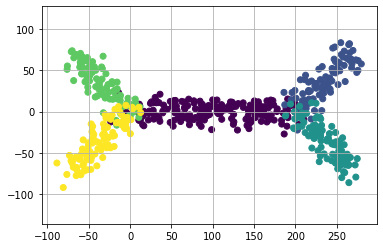

In [14]:
def make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] ):
  '''
  '''

  """
  n_layers = 2
  n_features = 2
  sigma_noise = 10.0
  plot_mode = 'PCA'
  n_samples4base = 200
  n_samples4branches = [100,100,100,100]
  angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4]
  """

  X_noiseless = np.zeros( (0,n_features))
  y_final = np.zeros( 0 )
  for layer in range(n_layers):
    current_label = 0 
    X = np.zeros( (n_samples4base, n_features) )
    X[:,0] = np.arange(n_samples4base)
    y = current_label * np.ones( n_samples4base )
    v_last_base_point_save = X[-1,:].copy()
    v_first_base_point_save = X[0,:].copy()

    # Make branches
    n_branches = len ( n_samples4branches )
    for c_branch in range( n_branches ) : # n_branches
      n_sample4branch = n_samples4branches[c_branch]
      current_label += 1
      y_branch = current_label * np.ones( n_sample4branch )
      angle = angles[c_branch] 
      if c_branch < n_branches/ 2:
        v_initial = v_last_base_point_save
      else:
        v_initial = v_first_base_point_save  
      X_branch = np.zeros( (n_sample4branch,  n_features)  ) #  [:2] = (np.cos(angle), np.sin(angle) )  
      v_direction = np.zeros( n_features)
      v_direction[0] = np.cos(angle)
      v_direction[1] = np.sin(angle)
      X_branch += v_direction # Broadcast vector to the whole array over axis 0 
      X_branch *= np.arange( 1, X_branch.shape[0] +1 ).reshape(X_branch.shape[0], 1 ) # Broadcast - mutiply each column by  by column = 1,2,3, ... 
      X_branch += v_initial # 
      X = np.concatenate( (X,X_branch) , axis = 0 )
      y = np.concatenate( (y, y_branch ))
    X_noiseless = np.concatenate( (X_noiseless,X) , axis = 0 )
    y_final = np.concatenate( (y_final,y) ) 
    
  X_noisy = X_noiseless + sigma_noise * np.random.randn( X_noiseless.shape[0], X_noiseless.shape[1] )


  y = y_final
  X = X_noisy

  if 0:
    print(X.shape, y.shape)
    r = X_noisy
    plt.scatter(r[:,0],r[:,1], c =y)
    plt.show()
  
  return X,y

X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )
if 1:
  print(X.shape, y.shape)
  r = X
  plt.scatter(r[:,0],r[:,1], c =y)
  plt.axis("equal")
  plt.grid()
  plt.show()


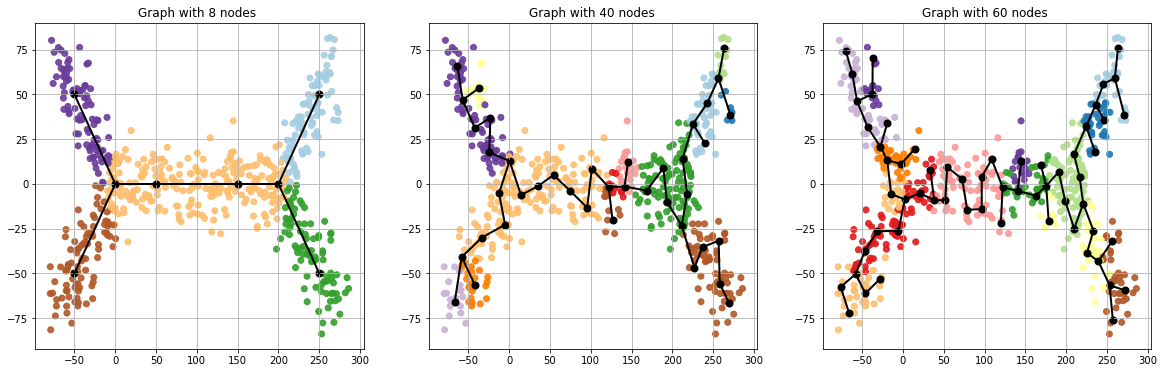

,Graph with 8 nodes,Graph with 40 nodes,Graph with 60 nodes
silhouette score,0.353467,0.270324,0.224438
Davies-Bouldin score,0.628863,0.877467,0.904066
Calinski-Harabasz score,797.851615,1131.458002,1223.113059


In [15]:
from sklearn import metrics
from sklearn.cluster import  KMeans
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree
import pandas as pd 


X,y = make_dumbbell(n_layers = 1, n_features = 2,  sigma_noise = 10.0, n_samples4base = 200,
                  n_samples4branches = [100,100,100,100] , angles = [np.pi/4,-np.pi/4,3*np.pi/4,-3*np.pi/4] )

#print(X.shape,'shape of output array X.', y.shape, 'shape of output y' )

df_scores_info = pd.DataFrame()

fig = plt.figure(figsize=(20, 6))
n_subplots_x = 3
c = 0 

c+=1 ; fig.add_subplot(1, n_subplots_x , c) 


# Create graph 
g = igraph.Graph()
g.add_vertices(8)
list_edges = [(0,1), (1,2),(1,3), (0,4),(0,5),(0,6),(6,7),(7,1) ]
g.add_edges( list_edges ) # Add list of edges 
nodes_positions = np.array([[0,0],[200,0], (250,50), (250,-50) , (-50,50), (-50,-50), (50,0), (150,0)])

vec_labels_by_branches = branch_labler( X , g, nodes_positions )

plot_graph(np.array(g.get_edgelist()), nodes_positions, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches, data_transparency_alpha = 0.9 )
plt.grid()

s = 'Graph with '+str(g.vcount()) +' nodes '
plt.title(s)
m = metrics.silhouette_score(X, vec_labels_by_branches, metric='euclidean')
df_scores_info.loc['silhouette score', s] = m
m = metrics.davies_bouldin_score(X, vec_labels_by_branches)
df_scores_info.loc['Davies-Bouldin score', s] = m
m = metrics.calinski_harabasz_score(X, vec_labels_by_branches)
df_scores_info.loc['Calinski-Harabasz score', s] = m




c+=1 ; fig.add_subplot(1, n_subplots_x , c) 

clustering = KMeans(n_clusters=40, random_state=0).fit(X)
cluster_centers_ = clustering.cluster_centers_
predicted_clusters = clustering.labels_ # kmeans.predict(X)
# sklearn.neighbors.kneighbors_graph(X, n_neighbors, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False, n_jobs=None)[source]¶
csr_knn = kneighbors_graph(cluster_centers_, n_neighbors= 10, mode= 'distance', include_self=True) # mode=  'connectivity'

csr_mst = minimum_spanning_tree(csr_knn)

g = igraph.Graph().Adjacency((csr_mst.todense() != 0).astype(int).tolist())
g.to_undirected(mode = 'collapse')

vec_labels_by_branches = branch_labler( X , g, cluster_centers_ )


plot_graph(np.array(g.get_edgelist()), cluster_centers_, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches, data_transparency_alpha = 0.9 )
plt.grid()

s = 'Graph with '+str(g.vcount()) +' nodes '
plt.title(s)
m = metrics.silhouette_score(X, vec_labels_by_branches, metric='euclidean')
df_scores_info.loc['silhouette score', s] = m
m = metrics.davies_bouldin_score(X, vec_labels_by_branches)
df_scores_info.loc['Davies-Bouldin score', s] = m
m = metrics.calinski_harabasz_score(X, vec_labels_by_branches)
df_scores_info.loc['Calinski-Harabasz score', s] = m


c+=1 ; fig.add_subplot(1, n_subplots_x , c) 

clustering = KMeans(n_clusters=60, random_state=0).fit(X)
cluster_centers_ = clustering.cluster_centers_
predicted_clusters = clustering.labels_ # kmeans.predict(X)
# sklearn.neighbors.kneighbors_graph(X, n_neighbors, mode='connectivity', metric='minkowski', p=2, metric_params=None, include_self=False, n_jobs=None)[source]¶
csr_knn = kneighbors_graph(cluster_centers_, n_neighbors= 10, mode= 'distance', include_self=True) # mode=  'connectivity'

csr_mst = minimum_spanning_tree(csr_knn)

g = igraph.Graph().Adjacency((csr_mst.todense() != 0).astype(int).tolist())
g.to_undirected(mode = 'collapse')

vec_labels_by_branches = branch_labler( X , g, cluster_centers_ )

plot_graph(np.array(g.get_edgelist()), cluster_centers_, data = X, dim_reduction = 'plot_first2axis', graph_color = 'black', graph_linewidth=2, 
               plot_data = True, data_linewidth = 1,  data_color = vec_labels_by_branches, data_transparency_alpha = 0.9 )
plt.grid()

s = 'Graph with '+str(g.vcount()) +' nodes '
plt.title(s)
m = metrics.silhouette_score(X, vec_labels_by_branches, metric='euclidean')
df_scores_info.loc['silhouette score', s] = m
m = metrics.davies_bouldin_score(X, vec_labels_by_branches)
df_scores_info.loc['Davies-Bouldin score', s] = m
m = metrics.calinski_harabasz_score(X, vec_labels_by_branches)
df_scores_info.loc['Calinski-Harabasz score', s] = m

plt.show()


df_scores_info
